## Comparing the performance of Gated Recurrent Units With and Without Attention
By learning to predict the text of H.G. Wells' The Time Machine

### Dataset

In [61]:
raw_text = open('../datasets/timemachine.txt').read()

### Let's tokenize the dataset


In [65]:
import re
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

# Remove punctuation and convert to lowercase
text = raw_text.lower()
text = re.sub(r'[^a-z]', ' ', text)

word_tokenized_text = text.split()

# Tokenize the text
tokenized_text = tokenizer.tokenize(text) 
tokenized_text[:10]

/Users/vikram/dev/xjax/.venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (39222 > 512). Running this sequence through the model will result in indexing errors


['project', 'gut', '##enberg', 's', 'the', 'time', 'machine', 'by', 'h', 'g']

In [69]:
# Most common tokens
from collections import Counter
# Flatten the list of tokens
# Count the tokens
token_counts = Counter(tokenized_text)
print(f"Total tokens: {len(token_counts)}")
# Most common tokens
most_common_tokens = token_counts.most_common(10)
for token, count in most_common_tokens:
    print(f"{token} {count}")

Total tokens: 4904
the 2441
and 1313
i 1275
of 1272
a 895
to 780
in 659
was 553
that 458
it 452


[2441, 1313, 1275, 1272, 895, 780, 659, 553, 458, 452, 441, 354, 289, 284, 266, 261, 248, 209, 207, 206, 199, 192, 169, 164, 158, 148, 146, 137, 137, 137, 135, 134, 133, 130, 129, 128, 125, 123, 122, 121, 119, 116, 115, 113, 106, 105, 104, 95, 94, 94, 93, 93, 92, 91, 91, 89, 89, 89, 89, 87, 86, 86, 79, 78, 78, 78, 78, 77, 76, 76, 75, 75, 75, 75, 75, 72, 71, 70, 69, 67, 67, 66, 64, 64, 63, 62, 61, 61, 61, 60, 59, 57, 57, 57, 56, 56, 55, 55, 54, 54, 52, 51, 51, 51, 50, 50, 50, 49, 49, 49, 49, 49, 48, 48, 48, 48, 48, 48, 48, 47, 47, 47, 47, 46, 45, 44, 43, 43, 42, 41, 41, 40, 40, 40, 40, 39, 39, 39, 38, 38, 38, 37, 37, 37, 37, 37, 36, 36, 36, 36, 36, 36, 35, 35, 35, 35, 35, 35, 35, 34, 34, 34, 34, 34, 33, 33, 33, 33, 33, 33, 32, 32, 32, 32, 31, 31, 31, 31, 31, 30, 30, 30, 30, 29, 29, 28, 28, 28, 28, 28, 28, 28, 28, 28, 27, 27, 27, 27, 27, 27, 26, 26, 26, 25, 25, 25, 25, 25, 25, 25, 24, 24, 24, 24, 24, 24, 24, 23, 23, 23, 23, 23, 23, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 

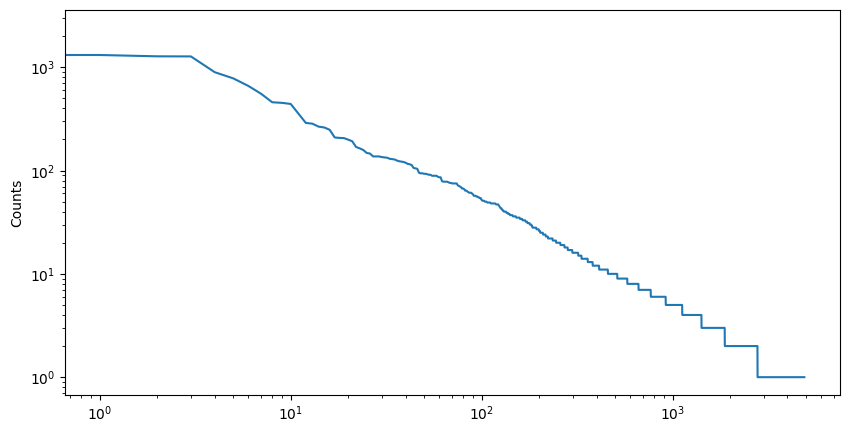

In [70]:
# Draw a graph of the token counts 
import matplotlib.pyplot as plt
# Get the tokens and counts
counts = [count for token, count in token_counts.items()]
# Sort the tokens and counts
sorted_indices = sorted(range(len(counts)), key=lambda i: counts[i], reverse=True)
sorted_counts = sorted(counts, reverse=True)
print(sorted_counts)
# Plot the counts using a log scale
plt.figure(figsize=(10, 5))
plt.loglog(sorted_counts)
plt.ylabel('Counts')
plt.show()

In [113]:
MIN_FREQ = 1 ## Minimum token frequency to include in the vocab

### Generate the Vocabulary
tok_to_idx = {}
idx_to_tok =  list(sorted(set(['<unk>'] + [tok for tok,count in token_counts.items() if count >= MIN_FREQ])))
tok_to_idx = {tok: idx for idx, tok in enumerate(idx_to_tok)}


# Vocabulary size
vocab_size = len(idx_to_tok)
print(f"Vocabulary size: {vocab_size}")



Vocabulary size: 2787


In [127]:
import jax.numpy as jnp

def sliding_window(seq, window_size, overlap):
    for i in range(0, len(seq) - window_size, window_size - overlap):
        yield [ tok_to_idx[tok] if tok in tok_to_idx else tok_to_idx['<unk>'] for tok in seq[i:i + window_size] ]


## Generate dataset 
def generate_data(text, seq_length, overlap):
    num_tokens = len(tokenized_text)
    return jnp.array([ seq for seq in sliding_window(tokenized_text, seq_length, overlap)])

In [130]:
SEQUENCE_LENGTH = 32
WINDOW_OVERLAP = 0

data = generate_data(text, SEQUENCE_LENGTH, WINDOW_OVERLAP)
X = data[:,:-1]
Y = data[:,1:]

print(X.shape, Y.shape)
print(X[0])
print(Y[0])


(1225, 31) (1225, 31)
[2033 1398  113 2193 2515 2554 1689  736 1399 1328 1440  126 1328  121
  148 2715 2537 1081   49 1555 1284 2515 2639 1859  566  568  610 1830
  893  553 2746]
[1398  113 2193 2515 2554 1689  736 1399 1328 1440  126 1328  121  148
 2715 2537 1081   49 1555 1284 2515 2639 1859  566  568  610 1830  893
  553 2746  533]
